In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# display all plots in notebook
%matplotlib inline

print("Numpy version: " + str(np.__version__))
print("Pandas version: " + str(pd.__version__))
print("Matplotlib version: " + str(matplotlib.__version__))
print("Seaborn version: " + str(sns.__version__))

Numpy version: 2.3.5
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2


### Read data

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

cols_to_keep = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

df = pd.read_csv(url, usecols = cols_to_keep)

### EDA

In [3]:
# display first 5 rows of data set
print(df.head())

   engine_displacement  horsepower  vehicle_weight  model_year  \
0                  170       159.0     3413.433759        2003   
1                  130        97.0     3149.664934        2007   
2                  170        78.0     3079.038997        2018   
3                  220         NaN     2542.392402        2009   
4                  210       140.0     3460.870990        2009   

   fuel_efficiency_mpg  
0            13.231729  
1            13.688217  
2            14.246341  
3            16.912736  
4            12.488369  


In [4]:
# summary statistics for 'fuel_efficiency_mpg'
summary = df['fuel_efficiency_mpg'].describe(percentiles = [0.25, 0.5, 0.75])
print("\nSummary statistics:")
print(summary)


Summary statistics:
count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64


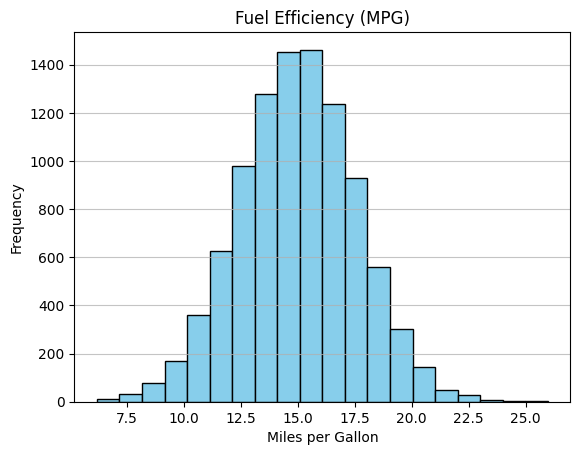

In [5]:
# histogram for 'fuel_efficiency_mpg'
plt.hist(df['fuel_efficiency_mpg'], bins = 20, 
         color = 'skyblue', edgecolor = 'black')
plt.title('Fuel Efficiency (MPG)')
plt.xlabel('Miles per Gallon')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

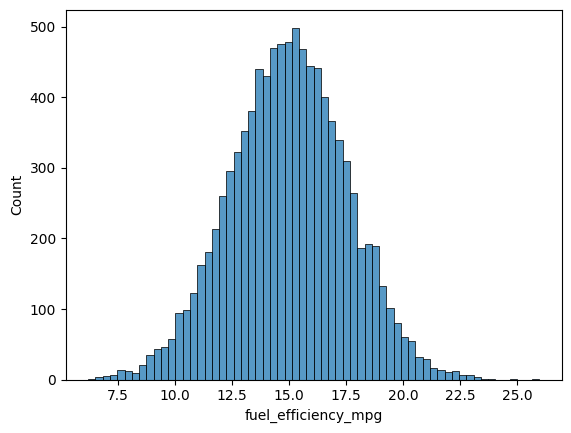

In [6]:
# use seaborn for the histogram
sns.histplot(df.fuel_efficiency_mpg)

In [7]:
df['fuel_efficiency_mpg'].skew().item()

-0.012062219273507962

`fuel_efficiency_mpg` is very normally distributed with no long tails and skewness virtually 0.

In [8]:
# list up to first 5 unique values for each column
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

engine_displacement
[170 130 220 210 190]
36

horsepower
[159.  97.  78.  nan 140.]
192

vehicle_weight
[3413.43375861 3149.66493422 3079.03899737 2542.39240183 3460.87098999]
9704

model_year
[2003 2007 2018 2009 2008]
24

fuel_efficiency_mpg
[13.23172891 13.68821744 14.246341   16.9127356  12.48836912]
9704



### Question 1. Missing values

In [9]:
### Q1: Missing values
print("Column missing value counts:\n")
print(df.isnull().sum())

num_missing_cols = df.isnull().any().sum()
print(f"\nThere are {num_missing_cols} columns with missing values.")

Column missing value counts:

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

There are 1 columns with missing values.


**'horsepower'** is the only column with missing values.


### Question 2. Median for `horsepower`

In [10]:
# Q2 Median
print(f"Median: {df['horsepower'].median():.2f}")

Median: 149.00


### Prepare and split the data

In [11]:
n = len(df)

n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_val - n_test
n, n_val + n_test + n_train

(9704, 9704)

In [12]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [13]:
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train + n_val]
df_test = df.iloc[n_train + n_val:]

In [14]:
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [15]:
# shuffle the training, validation, and test data
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [16]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [17]:
df_train.head(3)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822


In [18]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [19]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [20]:
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

### Question 3. Filling NAs

In [21]:
# define functions for linear regression with quantitative features and rmse
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    # regularization by adding small amount to diagonal
    XTX = X.T.dot(X) + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

# calculate RMSE
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X(df, fill_method = 'zeros'):
    df = df.copy()
    features = base.copy()

    df_num = df[features]

    if fill_method == 'zeros':
        df_num = df_num.fillna(0)
    elif fill_method == 'mean':
        df_num = df_num.fillna(df_num.mean())
    elif fill_method == 'median':
        df_num = df_num.fillna(df_num.median())
    X = df_num.values
    return X


In [22]:
# fill NAs with 0, train a linear regression model, calculate RMSE
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

# train
X_train = prepare_X(df_train, fill_method = 'zeros')
w0, w = train_linear_regression(X_train, y_train)

# validation
X_val = prepare_X(df_val, fill_method = 'zeros')
y_pred = w0 + X_val.dot(w)

score = round(rmse(y_val, y_pred).item(), 8)
print(score)

0.51737826


<Axes: ylabel='Count'>

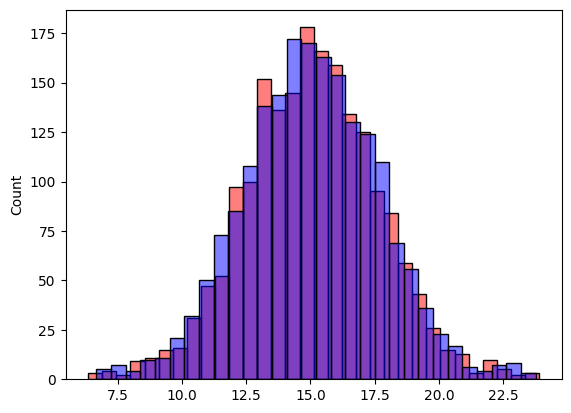

In [23]:
# use seaborn to overlay training values and their predictions
sns.histplot(y_pred, color = 'red', alpha = 0.5)
sns.histplot(y_val, color = 'blue', alpha = 0.5)

In [24]:
# fill NAs with mean, train a linear regression model, calculate RMSE

# train
X_train = prepare_X(df_train, fill_method = 'mean')
w0, w = train_linear_regression(X_train, y_train)

# validation
X_val = prepare_X(df_val, fill_method = 'mean')
y_pred = w0 + X_val.dot(w)

score = round(rmse(y_val, y_pred).item(), 8)
print(score)

0.4636237


<Axes: ylabel='Count'>

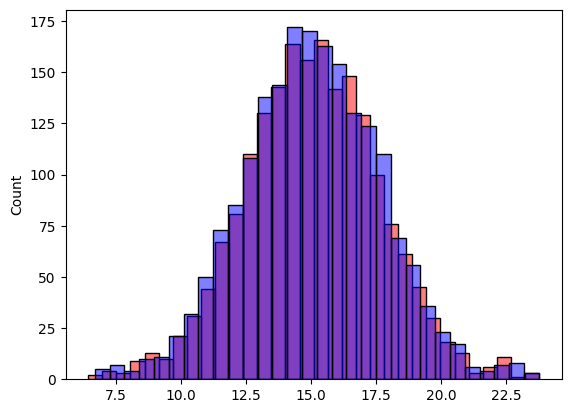

In [25]:
# use seaborn to overlay training values and their predictions
sns.histplot(y_pred, color = 'red', alpha = 0.5)
sns.histplot(y_val, color = 'blue', alpha = 0.5)

In [26]:
# fill NAs with median, train a linear regression model, calculate RMSE

# train
X_train = prepare_X(df_train, fill_method = 'median')
w0, w = train_linear_regression(X_train, y_train)

# validation
X_val = prepare_X(df_val, fill_method = 'median')
y_pred = w0 + X_val.dot(w)

score = round(rmse(y_val, y_pred).item(), 8)
print(score)

0.46357255


### Question 4. Best regularization

In [27]:
# fill NAs with 0, train a linear regression model with regularization, calculate RMSE

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train, fill_method = 'zeros')
    w0, w = train_linear_regression_reg(X_train, y_train, r = r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0 28.827365474906305 0.5173782638841655
0.01 24.92683842015079 0.517111552576255
0.1 11.239661085122432 0.5187525130701096
1 1.7315979412351166 0.5222348802092595
5 0.3638075020636705 0.522891609282353
10 0.1830624662271185 0.5229812979636556
100 0.018418017307786222 0.5230636233819932


In [28]:
X_train = prepare_X(df_train, fill_method = 'zeros')
w0, w = train_linear_regression_reg(X_train, y_train, r = 0)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
round(score, 2).item()

0.52

### Question 5. RMSE standard deviation

In [29]:
# evaluate model stability across different seeds
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds:
    np.random.seed(seed)

    # shuffle indices
    idx = np.arange(n)
    np.random.shuffle(idx)

    # 60/20/20 split
    n_test = int(n * 0.2)
    n_val = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df.iloc[idx[:n_train]].reset_index(drop = True)
    df_val = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop = True)
    df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop = True)

    # prepare data
    X_train = prepare_X(df_train, fill_method = 'zeros')
    y_train = df_train.fuel_efficiency_mpg.values

    X_val = prepare_X(df_val, fill_method = 'zeros')
    y_val = df_val.fuel_efficiency_mpg.values

    # train without regularization
    w0, w = train_linear_regression(X_train, y_train)

    # predict and evaluate
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    scores.append(score)

    print(f"Seed = {seed}, RMSE = {score:.3f}")

# compute standard deviation of RMSEs
std = np.std(scores)
print("Standard deviation of RMSE scores:", round(std, 10))

Seed = 0, RMSE = 0.521
Seed = 1, RMSE = 0.521
Seed = 2, RMSE = 0.523
Seed = 3, RMSE = 0.516
Seed = 4, RMSE = 0.511
Seed = 5, RMSE = 0.528
Seed = 6, RMSE = 0.531
Seed = 7, RMSE = 0.509
Seed = 8, RMSE = 0.515
Seed = 9, RMSE = 0.513
Standard deviation of RMSE scores: 0.0069894464


### Question 6. Evaluation on test

In [30]:
# final model using seed = 9
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

# 60/20/20 split
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop = True)
df_val = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop = True)
df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop = True)

# combine train and validation data
df_full_train = pd.concat([df_train, df_val]).reset_index(drop = True)

# prepare X and y
X_full_train = prepare_X(df_full_train, fill_method = 'zeros')
y_full_train = df_full_train.fuel_efficiency_mpg.values

X_test = prepare_X(df_test, fill_method = 'zeros')
y_test = df_test.fuel_efficiency_mpg.values

# train ridge regression with r = 0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r = 0.001)

# predict on test set
y_pred = w0 + X_test.dot(w)
test_rmse = rmse(y_test, y_pred)

print("Test RMSE (r = 0.001, seed = 9):", round(test_rmse, 3))

Test RMSE (r = 0.001, seed = 9): 0.516
